# Titanic - Machine Learning from Disaster Project Overview

### 1. Problem Definition
This is a playground Kaggle Competition: https://www.kaggle.com/c/titanic
* While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
* Given some features of someone, predict whether he will survive from Titanic shipwreck or not. 

### 2. Data 
Data is also available from Kaggle: https://www.kaggle.com/c/titanic/data

**Overview**

The data has been split into two groups:
* training set (train.csv)
* test set (test.csv)

Here are main variables.
1. survival: 1 is Yes, 0 is No.
  * this is **Label** We want to predict.
2. Age: age in years
  * It maybe relates to survival, say eldery is more difficult to survive that youngesters.
3. pclass: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower


### 3. Evaluation
Evaluation metrics is `accuracy`. https://www.kaggle.com/c/titanic/overview/evaluation

I would like to build a model with:
* 90% accuracy
Also, I should monitor precision, recall, and f1.

Even if the accuracy is great, I reject the model if another metrics were terrible.

### 4. Features
Just guessing, with seeing no nodata, Age itself affects survival.
Also, sex and cabin seem to have impact.

#### **Data manipulation**
- 1. drop Cabin
- 2. drop PassengerId
- 3. drop Name
- 4. Turn Sex into "is_female" and drop Sex
- 5. <font color=red>Age imputation</font>
  - 5-1. midium of each Parch
   - 5-1-1. age binning (Age_class)
  - 5-2. midium of each SibSp
  - 5-3. (average, max, min) of 5-1 and 5-2
  - 5-4. sqet of 5-1 and 5-2
- 6. drop Ticket 
- 7. Fare binning
### 5. Model
- Cross Validation

The problem is binary classification.
<img src="https://drive.google.com/uc?id=1FGvA69pXd97vrEeumbVIvRccvUrYYrPF" width="600">
 https://www.analyticsvidhya.com/blog/2020/11/popular-classification-models-for-machine-learning/

I will choose model after analyzing features.


# Import nacessary tools


In [52]:
# EDA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.optimize import curve_fit

import re

#  Data
* a. Unzip data



```
 !unzip drive/MyDrive/Github/Kaggle/Titanic/data.zip -d drive/MyDrive/Github/Kaggle/Titanic

 Archive:  drive/MyDrive/Github/Kaggle/Titanic/data.zip
  inflating: drive/MyDrive/Github/Kaggle/Titanic/gender_submission.csv  
  inflating: drive/MyDrive/Github/Kaggle/Titanic/test.csv  
  inflating: drive/MyDrive/Github/Kaggle/Titanic/train.csv  
```



In [93]:
import dataclasses
def iqr_boundary(data,rate=1.5):
  """
  Return IQR and normal interval

  upper = Q3 +1.5*IQR
  lower = Q1 – 1.5*IQR

  data: list like 
  """
  x = list(data) 
  # IQR
  Q1 = np.percentile(x, 25,
                    interpolation = 'midpoint')
  
  Q2 = np.percentile(x, 50,
                    interpolation = 'midpoint')  
  
  Q3 = np.percentile(x, 75,
                    interpolation = 'midpoint')
  IQR = Q3 - Q1

  # Above Upper bound
  upper = Q3+ rate*IQR

  # Below Lower bound
  lower = Q1- rate*IQR

  print(f"Q1: {Q1}, Q2: {Q2}, Q3: {Q3} ,normal boundary: from {lower} to {upper}")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Github/Kaggle/Titanic/data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
len(df)

891



```
df.isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
```



## Missing data treatment
First of all, are there any missing?
- Cabin: Most of them is missing. I cannot use this information. However, Are there any difference between survival?
- Age: How about inferring from another feature?

## Exploring data one by one
From right to left, one by one.

### Passenger Id
Id should be included in the output, but it should be separated from training dataset.

In [ ]:
#drop passenger id
df_manipulate2 = df_manipulate1.drop(["PassengerId"],axis=1)
df_manipulate2.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Pclass
What's that?

A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

Are there any difference of survival rate between socio-economic status?

If so, that should be no surprise.

In [ ]:
pd.crosstab(df.Pclass,df.Survived)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


**Hypothesis**

It seems that socio-economic status significantly affects survival.

Because I will build a model to test this hypothesis, there is no need to do ANOVA or something.

### Name
I don't know how to handle this. So let's start cursively look over them.

Well, who cares?

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==1][df_manipulate2["Survived"]==1][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==3][df_manipulate2["Survived"]==1][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==1][df_manipulate2["Survived"]==0][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==3][df_manipulate2["Survived"]==0][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate3 = df_manipulate2.drop(["Name"],axis=1)
df_manipulate3.head()

### Sex
Basically female survived, and vice versa.

Null hypothesis (Ho): Sex has no impact whether to survive or not.

However, chi square says we reject the Ho.

- Sex has impact on survival

Thus, feature of "is_female" is better than two features of "male" and "female"

In [ ]:
chi2_contingency(pd.crosstab(df_manipulate3["Sex"],df_manipulate3["Survived"]))

Survived,0,1
Sex,,
female,81,233
male,468,109


In [ ]:
chi2, p, df, exected = chi2_contingency(pd.crosstab(df_manipulate3["Sex"],df_manipulate3["Survived"]))
print(f"p-value: {p}")

p-value: 1.1973570627755645e-58


In [ ]:
df_manipulate4 = df_manipulate3.copy()
df_manipulate4["is_female"] = df_manipulate3["Sex"] == "female"
df_manipulate4.drop("Sex", axis=1,inplace=True)
df_manipulate4.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True
3,1,1,35.0,1,0,113803,53.1000,S,True
4,0,3,35.0,0,0,373450,8.0500,S,False


### Cabin
**Null hypothesis (Ho)** : Cabin missing has no effect on survival.
1. Cabin missin has no significant effect on survival ( aka. failed to reject Ho)
2. Cabin missing accounts for 70%

Thus, Cabin should be omitted from training dataset.

In [ ]:
df_tmp = pd.crosstab(df.Survived,df["Cabin"].isna())

Cabin,False,True
Survived,,
0,68,481
1,136,206


In [ ]:
chi2, p, df, exected = chi2_contingency(df_tmp)
print(f"p-value: {p}")

p-value: 0.2421723039557977


In [ ]:
## Data manipulation no.1 drop Cabin
df_manipulate1 = df.drop(["Cabin"],axis=1)
df_manipulate1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Age
Things to consider:
- filling missing values or delete
- treat outlier
- create age class

#### Description

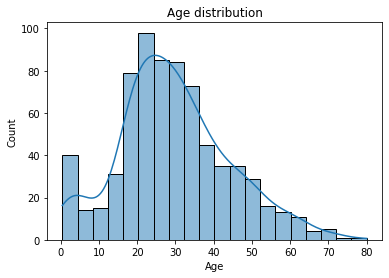

In [ ]:
fig, ax = plt.subplots()

sns.histplot(df.Age,kde=True, ax=ax);
ax.set(title="Age distribution");

In [ ]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


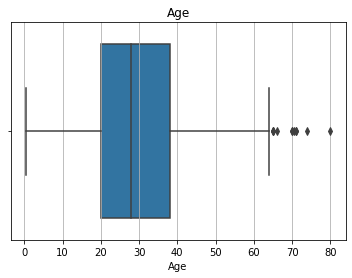

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(df_manipulate4["Age"], ax=ax);
ax.xaxis.grid(True);
ax.set(title="Age");

#### What affects age?

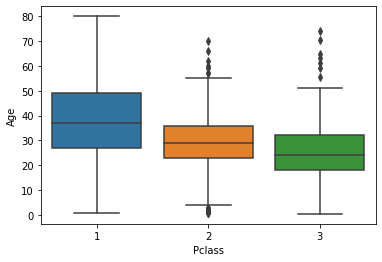

In [ ]:
sns.boxplot(x=df_manipulate4["Pclass"],y=df_manipulate4["Age"]);

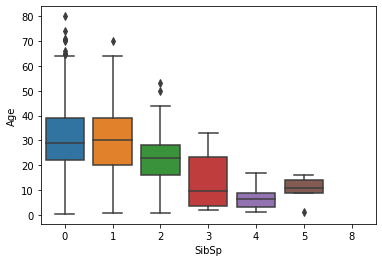

In [ ]:
sns.boxplot(x=df_manipulate4["SibSp"],y=df_manipulate4["Age"]);

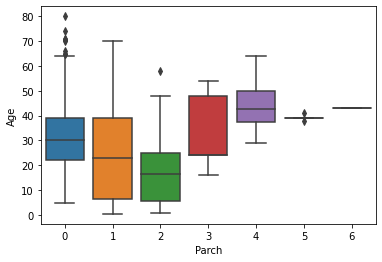

In [ ]:
sns.boxplot(x=df_manipulate4["Parch"],y=df_manipulate4["Age"]);

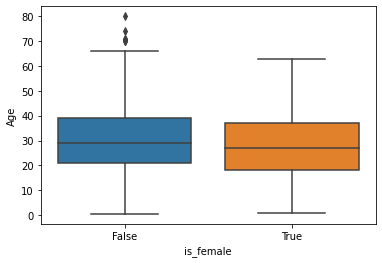

In [ ]:
sns.boxplot(x=df_manipulate4["is_female"],y=df_manipulate4["Age"]);

In [ ]:
df_manipulate4.groupby(["Parch"])["Age"].median()

Parch
0    30.0
1    23.0
2    16.5
3    24.0
4    42.5
5    39.0
6    43.0
Name: Age, dtype: float64

In [ ]:
df_manipulate4.groupby(["SibSp"])["Age"].median()

SibSp
0    29.0
1    30.0
2    23.0
3     9.5
4     6.5
5    11.0
8     NaN
Name: Age, dtype: float64

In [ ]:
pd.crosstab(df.Age[df.Age<=20],df.Parch)

Parch,0,1,2,3
Age,,,,
0.42,0,1,0,0
0.67,0,1,0,0
0.75,0,2,0,0
0.83,0,1,1,0
0.92,0,0,1,0
1.00,0,3,4,0
2.00,0,7,3,0
3.00,0,4,2,0
4.00,0,6,4,0


In [ ]:
df[df["Age"]<=10][df["Parch"]==0][df["SibSp"]==0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
777,778,1,3,"Emanuel, Miss. Virginia Ethel",female,5.0,0,0,364516,12.475,NaN,S


**<font color=red>5 year old and no Parents?? No way!**

Miss Virginia Ethel Emanuel, 5, boarded the Titanic at Southampton with her Nurse Miss Elizabeth Fierer who was escorting her to her grandparents home in New York, NY.
https://www.geni.com/people/Virginia-Ethel-Emanuel/6000000039819990813

In [ ]:
df_manipulate4.head(0)

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female


#### Age imputing ( Method 1)

In [ ]:
df_manipulate4.to_csv("drive/MyDrive/Github/Kaggle/Titanic/train_manipulate_to_4",index=False)

In [3]:
df2 = pd.read_csv("drive/MyDrive/Github/Kaggle/Titanic/train_manipulate_to_4")
df2.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True
3,1,1,35.0,1,0,113803,53.1000,S,True
4,0,3,35.0,0,0,373450,8.0500,S,False


In [5]:
df2_manipulate1 = df2.copy()
df2_manipulate1["Age_is_missing"] = df2.Age.isna()

###### Mehod 1. median of Parch

In [6]:
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 0),
                    'Age'] = 30
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 1),
                    'Age'] = 23
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 2),
                    'Age'] = 17                    
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 3),
                    'Age'] = 24
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 4),
                    'Age'] = 43
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 5),
                    'Age'] = 39        
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 6),
                    'Age'] = 43                                                            

In [7]:
df2_manipulate1["Age"].isna().sum()

0

In [ ]:
df2_manipulate1.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female,Age_is_missing
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True,False
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True,False
3,1,1,35.0,1,0,113803,53.1000,S,True,False
4,0,3,35.0,0,0,373450,8.0500,S,False,False


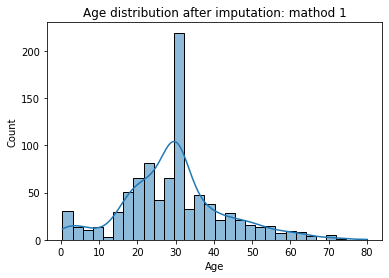

In [ ]:
fig, ax = plt.subplots()

sns.histplot(df2_manipulate1.Age,kde=True, ax=ax);
ax.set(title="Age distribution after imputation: mathod 1");

In [ ]:
iqr_boundary(df2_manipulate1["Age"])

Q1: 22.0, Q2: 30.0, Q3: 35.0 ,noramal boundary: from 2.5 to 54.5


In [23]:
# Binning by quantile and label `outlier`
df2_manipulate2 = df2_manipulate1.copy()
df2_manipulate2.loc[(2.5 <= df2_manipulate1['Age'])&(df2_manipulate1['Age']<=22.0),
                    'Age_class'] = "Q1"
df2_manipulate2.loc[(22.0 < df2_manipulate1['Age'])&(df2_manipulate1['Age']<=30.0),
                    'Age_class'] = "Q2"
df2_manipulate2.loc[(30.0 < df2_manipulate1['Age'])&(df2_manipulate1['Age']<=35.0),
                    'Age_class'] = "Q3"                   
df2_manipulate2.loc[(35.0 < df2_manipulate1['Age'])&(df2_manipulate1['Age']<=54.5),
                    'Age_class'] = "Q4"

df2_manipulate2["Age_is_outlier"] = df2_manipulate2["Age_class"].isna()

df2_manipulate2.loc[df2_manipulate1['Age']<2.5,
                    'Age_class'] = "Q1"
df2_manipulate2.loc[54.5 < df2_manipulate1['Age'],
                    'Age_class'] = "Q1"                    

In [25]:
df2_manipulate2[df2_manipulate2["Age_is_outlier"]==True].head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier
7,0,3,2.0,3,1,349909,21.075,S,False,False,Q1,True
11,1,1,58.0,0,0,113783,26.550,S,True,False,Q1,True
15,1,2,55.0,0,0,248706,16.000,S,True,False,Q1,True
16,0,3,2.0,4,1,382652,29.125,Q,False,False,Q1,True
33,0,2,66.0,0,0,C.A. 24579,10.500,S,False,False,Q1,True


### SibSp and Parch
- In 891 people, most of their "SibSp" and "Parch" is 0, 1 or 2.
- Also, major amount of people **alone**.
  - another chanece: with friends or cowarkers
- 2nd major group is **SibSp = 1 and Parch = 0** means with spouse or with sibling.

In [26]:
df2_manipulate2.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False,False,Q1,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True,False,Q4,False
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True,False,Q2,False
3,1,1,35.0,1,0,113803,53.1000,S,True,False,Q3,False
4,0,3,35.0,0,0,373450,8.0500,S,False,False,Q3,False


In [27]:
pd.crosstab(df2_manipulate2.Survived,df2_manipulate2.SibSp)

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,210,112,13,4,3,0,0


In [28]:
pd.crosstab(df2_manipulate2.Survived,df2_manipulate2.Parch)

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


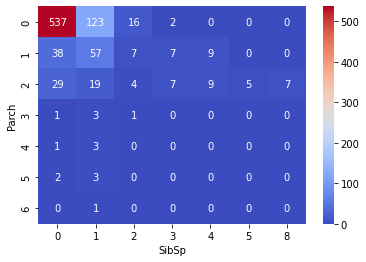

In [29]:
ax = sns.heatmap(pd.crosstab(df2_manipulate2.Parch,df2_manipulate2.SibSp),annot=True, fmt="d",cmap="coolwarm");

### Ticket
ticket number and survival??
- I tried to handle with this data, but this should be ignored.

In [82]:
df2_manipulate3 = df2_manipulate2.copy()
df2_manipulate3 = df2_manipulate3.drop("Ticket",axis=1)

In [86]:
df2_manipulate3.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier
0,0,3,22.0,1,0,7.2500,S,False,False,Q1,False
1,1,1,38.0,1,0,71.2833,C,True,False,Q4,False
2,1,3,26.0,0,0,7.9250,S,True,False,Q2,False
3,1,1,35.0,1,0,53.1000,S,True,False,Q3,False
4,0,3,35.0,0,0,8.0500,S,False,False,Q3,False


### Fare
I assume that fare and survival have a positive correlation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


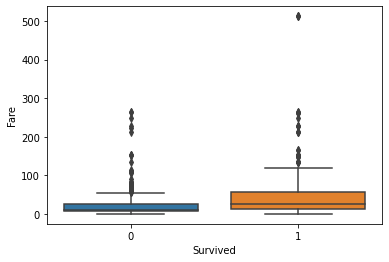

In [100]:
sns.boxplot(df2_manipulate3.Survived,df2_manipulate3.Fare);

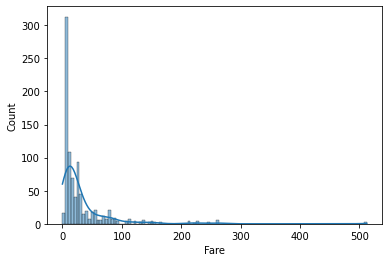

In [102]:
sns.histplot(df2_manipulate3.Fare,kde=True);

In [96]:
iqr_boundary(df2_manipulate3.Fare)

Q1: 7.9104, Q2: 14.4542, Q3: 31.0 ,normal boundary: from -26.724 to 65.6344


In [94]:
iqr_boundary(df2_manipulate3.Fare[df2_manipulate3.Survived==1])

Q1: 12.475, Q2: 26.0, Q3: 57.0 ,normal boundary: from -54.31249999999999 to 123.7875


In [95]:
iqr_boundary(df2_manipulate3.Fare[df2_manipulate3.Survived==0])

Q1: 7.8542, Q2: 10.5, Q3: 26.0 ,normal boundary: from -19.364500000000003 to 53.2187


In [107]:
# Fare binning
df2_manipulate4 = df2_manipulate3.copy()
df2_manipulate4.loc[df2_manipulate3['Fare']<=7.9,
                    'Fare_class'] = "Q1"
df2_manipulate4.loc[(7.9 < df2_manipulate3['Fare'])&(df2_manipulate3['Fare']<=14.5),
                    'Fare_class'] = "Q2"
df2_manipulate4.loc[(14.5 < df2_manipulate3['Fare'])&(df2_manipulate3['Fare']<=31.0),
                    'Fare_class'] = "Q3"                   
df2_manipulate4.loc[(31.0 < df2_manipulate3['Fare'])&(df2_manipulate3['Fare']<=65.7),
                    'Fare_class'] = "Q4"

df2_manipulate4["Fare_is_outlier"] = df2_manipulate4["Fare_class"].isna()

df2_manipulate4.loc[65.7 < df2_manipulate3['Fare'],
                    'Fare_class'] = "Q4"     

In [108]:
df2_manipulate4.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier,Fare_class,Fare_is_outlier
0,0,3,22.0,1,0,7.2500,S,False,False,Q1,False,Q1,False
1,1,1,38.0,1,0,71.2833,C,True,False,Q4,False,Q4,True
2,1,3,26.0,0,0,7.9250,S,True,False,Q2,False,Q2,False
3,1,1,35.0,1,0,53.1000,S,True,False,Q3,False,Q4,False
4,0,3,35.0,0,0,8.0500,S,False,False,Q3,False,Q2,False


### Embarked
- only 2 missing value

In [127]:
df2_manipulate5 = df2_manipulate4.copy()
df2_manipulate5["Embarked_is_missing"] = df2_manipulate5["Embarked"].isna()
df2_manipulate5["Embarked"].fillna("missing",inplace=True)

In [128]:
df2_manipulate5[df2_manipulate5["Embarked"]=="missing"]

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier,Fare_class,Fare_is_outlier,Embarked_is_missing
61,1,1,38.0,0,0,80.0,missing,True,False,Q4,False,Q4,True,True
829,1,1,62.0,0,0,80.0,missing,True,False,Q1,True,Q4,True,True


In [129]:
pd.crosstab(df2_manipulate5.Embarked,df2_manipulate5.Survived)

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217
missing,0,2


# Today's plan
- chisq of embarked
- encoding
- build a model

# Near Future  <font color=apple>(worked)<font>
- <font color = apple>Age binning</font>
- SibSp and Parch --> Turn to category <font color = apple>(pending)</font>
- Ticket: <font color = apple>too difficult to handle</font>
- <font color=apple>Fare binning</font>
- Embarked: groupby